In [7]:
import numpy as np
import pandas as pd
import torch.nn as nn
import os
import torch
from PIL import Image
import matplotlib.pyplot as plt
from torchvision import transforms
from tqdm import tqdm

Loaded 1000 images with shape: torch.Size([1000, 1, 64, 64])
Loaded 1000 targets with shape: torch.Size([1000, 64, 64])


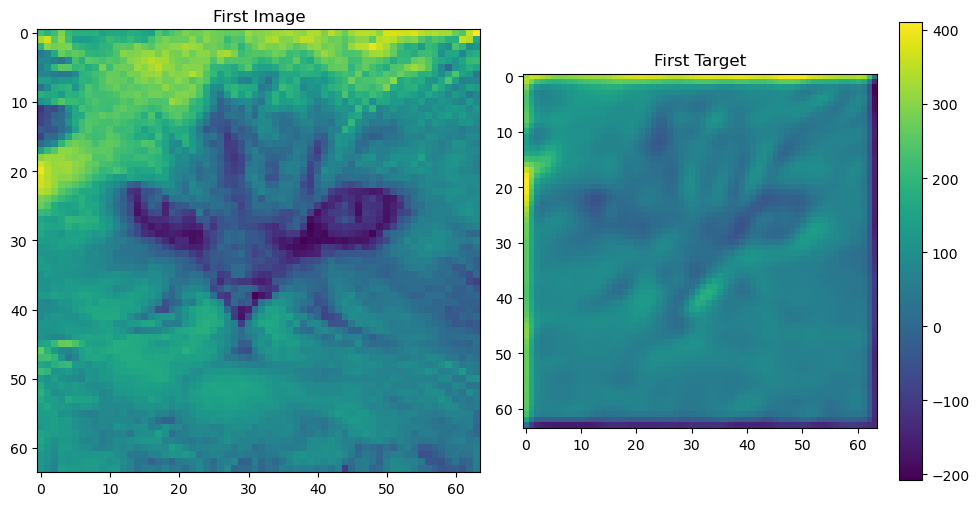

In [8]:
# Get list of all image 
folder = 'best_pictures'
image_files = sorted([f for f in os.listdir(folder) if f.endswith('.png')])
target_files = sorted([f for f in os.listdir(folder) if f.endswith('.txt')])

# Create lists to store loaded data
images = []
targets = []

# Define image transformation
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert PIL Image to tensor and scale to [0, 1]
])

# Load each image and its corresponding target
for img_file, target_file in zip(image_files, target_files):
    # Load and transform image
    img_path = os.path.join(folder, img_file)
    image = Image.open(img_path)
    image_tensor = transform(image)
    images.append(image_tensor)
    
    # Load target matrix from txt file
    target_path = os.path.join(folder, target_file)
    target_matrix = np.loadtxt(target_path)
    target_tensor = torch.tensor(target_matrix, dtype=torch.float32)
    targets.append(target_tensor)

# Convert lists to tensors
images = torch.stack(images)
targets = torch.stack(targets)

# Print shapes to verify
print(f"Loaded {len(images)} images with shape: {images.shape}")
print(f"Loaded {len(targets)} targets with shape: {targets.shape}")

# Display first image and its target as an example
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(images[0].permute(1, 2, 0))  # Convert from CxHxW to HxWxC for display
plt.title("First Image")
plt.subplot(1, 2, 2)
plt.imshow(targets[0], cmap='viridis')
plt.title("First Target")
plt.colorbar()
plt.tight_layout()
plt.show()

In [9]:
kernel_A = np.array([[-1.0,-0.5,0.0],[-0.5,0.5,0.5], [0.0,0.5,1.0]])
kernel_B = np.array([[0.0625,0.0625,0.0625,],[0.0625,0.0625,0.0625,], [0.0625,0.0625,0.0625]])

In [10]:
# Define the KaiNet models with different filter orders

class KaiNetModel(nn.Module):
    def __init__(self, filter_order, trainable_init=None):
        super(KaiNetModel, self).__init__()
        
        # Convert numpy kernels to torch tensors and reshape for conv2d (out_channels, in_channels, height, width)
        self.kernel_A = torch.tensor(kernel_A, dtype=torch.float32).unsqueeze(0).unsqueeze(0)
        self.kernel_B = torch.tensor(kernel_B, dtype=torch.float32).unsqueeze(0).unsqueeze(0)
        
        # Initialize the trainable kernel (C)
        if trainable_init is None:
            # Random initialization if not provided
            trainable_init = torch.randn(3, 3) * 0.01
        
        self.kernel_C = nn.Parameter(torch.tensor(trainable_init, dtype=torch.float32).unsqueeze(0).unsqueeze(0))
        
        # Create the filters as conv2d layers with fixed weights
        self.filter_A = nn.Conv2d(1, 1, kernel_size=3, padding=1, bias=False)
        self.filter_A.weight = nn.Parameter(self.kernel_A, requires_grad=False)
        
        self.filter_B = nn.Conv2d(1, 1, kernel_size=3, padding=1, bias=False)
        self.filter_B.weight = nn.Parameter(self.kernel_B, requires_grad=False)
        
        self.filter_C = nn.Conv2d(1, 1, kernel_size=3, padding=1, bias=False)
        self.filter_C.weight = self.kernel_C  # This one is trainable
        
        # Store the filter order
        self.filter_order = filter_order
        
    def forward(self, x):
        # Apply filters in the specified order
        for filter_idx in self.filter_order:
            if filter_idx == 'A':
                x = self.filter_A(x)
            elif filter_idx == 'B':
                x = self.filter_B(x)
            elif filter_idx == 'C':
                x = self.filter_C(x)
        return x

# Create all possible permutations of the three filters
# ABC, ACB, BAC, BCA, CAB, CBA
model_ABC = KaiNetModel(filter_order=['A', 'B', 'C'])
model_ACB = KaiNetModel(filter_order=['A', 'C', 'B'])
model_BAC = KaiNetModel(filter_order=['B', 'A', 'C'])
model_BCA = KaiNetModel(filter_order=['B', 'C', 'A'])
model_CAB = KaiNetModel(filter_order=['C', 'A', 'B'])
model_CBA = KaiNetModel(filter_order=['C', 'B', 'A'])

# Define loss function
criterion = nn.MSELoss()

# Print model summaries
print("Model ABC:", model_ABC)
print("Trainable parameters:", sum(p.numel() for p in model_ABC.parameters() if p.requires_grad))

Model ABC: KaiNetModel(
  (filter_A): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (filter_B): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (filter_C): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
)
Trainable parameters: 9


/var/folders/d3/zcslj2712p57dfxhz77sfh8r0000gn/T/ipykernel_5227/3332492013.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.kernel_C = nn.Parameter(torch.tensor(trainable_init, dtype=torch.float32).unsqueeze(0).unsqueeze(0))


In [11]:
# Training pipeline for all models with batches

# Create a dictionary to store all models
models = {
    'ABC': model_ABC,
    'ACB': model_ACB,
    'BAC': model_BAC,
    'BCA': model_BCA,
    'CAB': model_CAB,
    'CBA': model_CBA
}

# Training parameters
learning_rate = 0.1
num_epochs = 500
batch_size = 1  # Adjust based on your dataset size and available memory
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Create DataLoader for batch processing
dataset = torch.utils.data.TensorDataset(images, targets)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Dictionary to store training losses for each model
training_losses = {model_name: [] for model_name in models.keys()}

In [12]:
# Train each model
for model_name, model in models.items():
    print(f"Training model {model_name}...")
    if model_name != "BCA": continue
    
    # Move model to device
    model = model.to(device)
    
    # Initialize optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
    # Training loop
    for epoch in tqdm(range(num_epochs), desc=f"Model {model_name}"):
        epoch_loss = 0.0
        batch_count = 0
        
        # Process batches
        for batch_images, batch_targets in dataloader:
            # Move batch to device
            batch_images = batch_images.to(device)
            batch_targets = batch_targets.to(device)
            
            # Forward pass
            outputs = model(batch_images)
            loss = criterion(outputs, batch_targets)
            
            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            # Accumulate loss
            epoch_loss += loss.item()
            batch_count += 1
        
        # Calculate average loss for the epoch
        avg_epoch_loss = epoch_loss / batch_count
        training_losses[model_name].append(avg_epoch_loss)
        
        # Print progress every 50 epochs
        if (epoch+1) % 50 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_epoch_loss:.6f}')
        if avg_epoch_loss < 0.001:
            print(f"\nTraining stopped early for model {model_name} after {epoch+1} epochs.")
            break
    
    print(f"Final loss for model {model_name}: {training_losses[model_name][-1]:.6f}")
    
    # Move model back to CPU to free up GPU memory
    model = model.cpu()

Training model ABC...
Training model ACB...
Training model BAC...
Training model BCA...


Model BCA:   0%|          | 0/500 [00:00<?, ?it/s]/opt/homebrew/anaconda3/lib/python3.11/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1, 64, 64])) that is different to the input size (torch.Size([1, 1, 64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Model BCA:  10%|█         | 50/500 [00:17<02:52,  2.62it/s]

Epoch [50/500], Loss: 0.000684


Model BCA:  20%|██        | 100/500 [00:37<02:55,  2.29it/s]

Epoch [100/500], Loss: 0.000000


Model BCA:  30%|███       | 150/500 [00:56<02:01,  2.88it/s]

Epoch [150/500], Loss: 0.000000


Model BCA:  40%|████      | 200/500 [01:12<01:40,  2.97it/s]

Epoch [200/500], Loss: 0.000547


Model BCA:  50%|█████     | 250/500 [01:30<01:44,  2.40it/s]

Epoch [250/500], Loss: 0.000000


Model BCA:  60%|██████    | 300/500 [01:50<01:07,  2.97it/s]

Epoch [300/500], Loss: 0.000000


Model BCA:  70%|███████   | 350/500 [02:11<01:04,  2.32it/s]

Epoch [350/500], Loss: 0.000483


Model BCA:  80%|████████  | 400/500 [02:33<00:37,  2.64it/s]

Epoch [400/500], Loss: 0.000000


Model BCA:  90%|█████████ | 450/500 [02:54<00:18,  2.76it/s]

Epoch [450/500], Loss: 0.000000


Model BCA: 100%|██████████| 500/500 [03:12<00:00,  2.60it/s]

Epoch [500/500], Loss: 0.000000
Final loss for model BCA: 0.000000
Training model CAB...
Training model CBA...


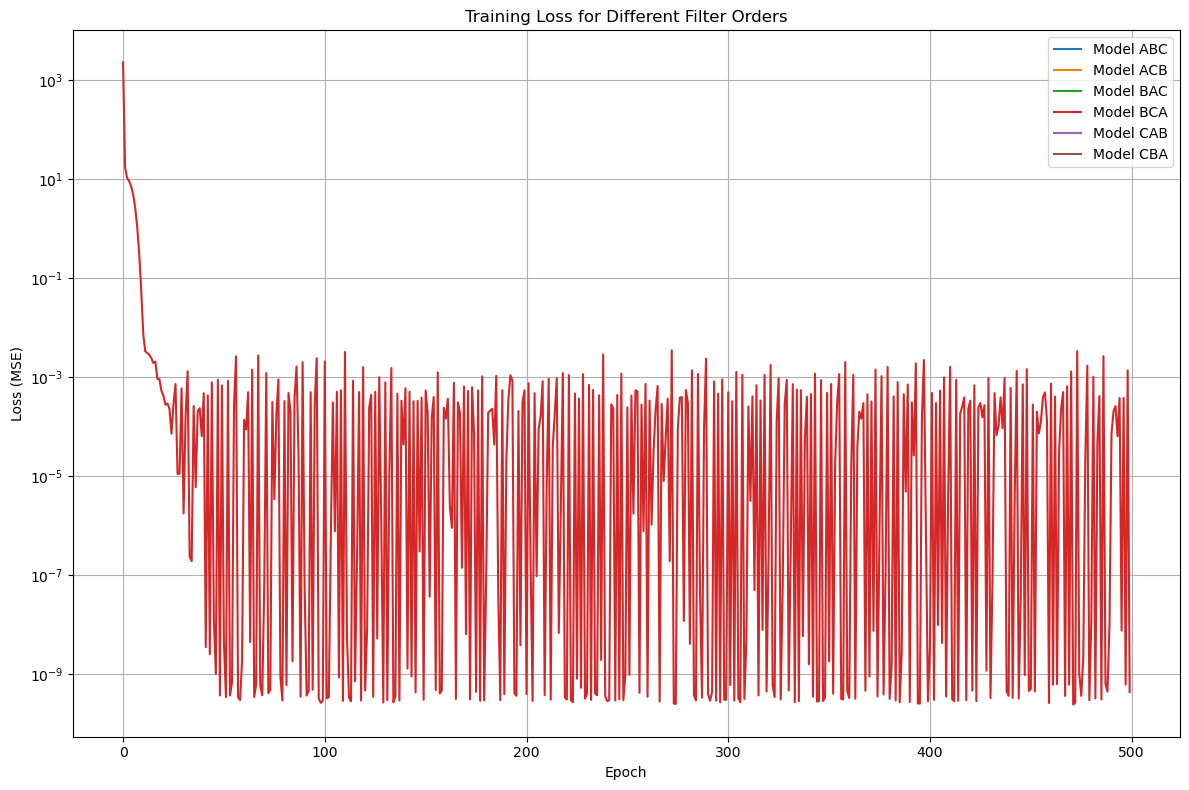

IndexError: list index out of range

In [13]:
# Plot training losses
plt.figure(figsize=(12, 8))
for model_name, losses in training_losses.items():
    plt.plot(losses, label=f'Model {model_name}')

plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.title('Training Loss for Different Filter Orders')
plt.legend()
plt.grid(True)
plt.yscale('log')  # Log scale to better visualize differences
plt.tight_layout()
plt.show()

# Find the two best models (lowest final loss)
final_losses = {model_name: losses[-1] for model_name, losses in training_losses.items()}
sorted_models = sorted(final_losses.items(), key=lambda x: x[1])

print("\nModels ranked by final loss:")
for i, (model_name, loss) in enumerate(sorted_models):
    print(f"{i+1}. Model {model_name}: {loss:.6f}")

print(f"\nThe two best models are: {sorted_models[0][0]} and {sorted_models[1][0]}")

# Plot the two best models separately for better visualization
plt.figure(figsize=(10, 6))
for i in range(2):
    best_model = sorted_models[i][0]
    plt.plot(training_losses[best_model], label=f'Model {best_model}')

plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.title('Training Loss for the Two Best Models')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Visualize the learned kernel C for the best model
best_model_name = sorted_models[0][0]
best_model = models[best_model_name]

learned_kernel = best_model.kernel_C.detach().cpu().numpy().squeeze()
plt.figure(figsize=(6, 6))
plt.imshow(learned_kernel, cmap='viridis')
plt.title(f'Learned Kernel C for Best Model ({best_model_name})')
plt.colorbar()
plt.grid(False)
plt.tight_layout()
plt.show()

# Compare original and predicted outputs for the best model
best_model = best_model.to(device)
with torch.no_grad():
    best_predictions = best_model(images).cpu()

# Display comparison for the first image
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.imshow(images[0].cpu().permute(1, 2, 0))
plt.title("Input Image")

plt.subplot(1, 3, 2)
plt.imshow(targets[0].cpu(), cmap='viridis')
plt.title("Target Output")
plt.colorbar()

plt.subplot(1, 3, 3)
plt.imshow(best_predictions[0], cmap='viridis')
plt.title(f"Predicted Output (Model {best_model_name})")
plt.colorbar()

plt.tight_layout()
plt.show()

# Calculate MSE for each model on the dataset
model_mse = {}
for model_name, model in models.items():
    model = model.to(device)
    with torch.no_grad():
        predictions = model(images)
        mse = criterion(predictions, targets).item()
    model_mse[model_name] = mse
    model = model.cpu()  

# Print MSE for each model
print("\nMSE for each model:")
for model_name, mse in sorted(model_mse.items(), key=lambda x: x[1]):
    print(f"Model {model_name}: {mse:.6f}")

In [16]:
print(models)

{'ABC': KaiNetModel(
  (filter_A): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (filter_B): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (filter_C): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
), 'ACB': KaiNetModel(
  (filter_A): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (filter_B): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (filter_C): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
), 'BAC': KaiNetModel(
  (filter_A): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (filter_B): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (filter_C): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
), 'BCA': KaiNetModel(
  (filter_A): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (filter_

Reconstructed algorithm saved to reconstructed_algos.csv

Reconstructed Algorithm (Filter Order): ['B', 'C', 'A']

Kernel A:
[[-1.  -0.5  0. ]
 [-0.5  0.5  0.5]
 [ 0.   0.5  1. ]]

Kernel B:
[[0.0625 0.0625 0.0625]
 [0.0625 0.0625 0.0625]
 [0.0625 0.0625 0.0625]]

Learned Kernel C:
[[ 31.875046  63.75029   31.87466 ]
 [ 63.749577 127.500084  63.75033 ]
 [ 31.875374  63.74963   31.874992]]


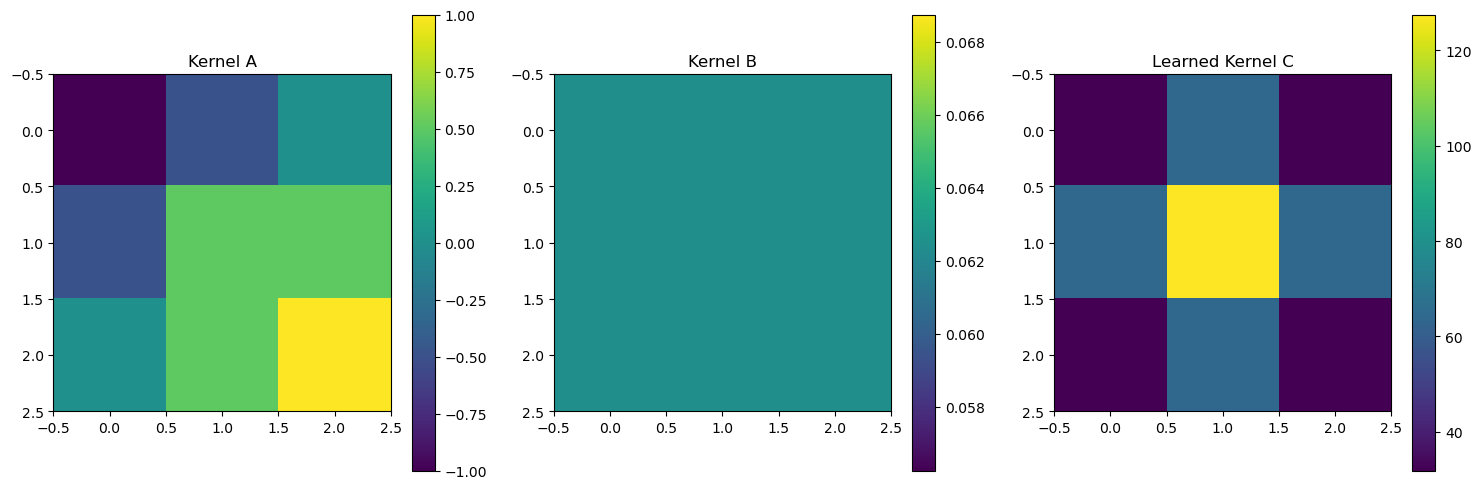


Verification of reconstructed_algos.csv content:
Filter B (row 1):
[[0.0625 0.0625 0.0625]
 [0.0625 0.0625 0.0625]
 [0.0625 0.0625 0.0625]]

Filter C (row 2):
[[ 31.87504578  63.75028992  31.87466049]
 [ 63.74957657 127.50008392  63.75033188]
 [ 31.87537384  63.74962997  31.87499237]]

Filter A (row 3):
[[-1.  -0.5  0. ]
 [-0.5  0.5  0.5]
 [ 0.   0.5  1. ]]



In [19]:

best_model = models['BCA']

# Save the model
# torch.save(best_model.state_dict(), 'best_kaiNet_model.pth')
# print(f"Best model ({best_model_name}) saved to best_kaiNet_model.pth")

# Extract the filter order and kernels
filter_order = best_model.filter_order
kernel_A_flat = kernel_A.flatten()
kernel_B_flat = kernel_B.flatten()
kernel_C_flat = best_model.kernel_C.detach().cpu().numpy().squeeze().flatten()

# Create the reconstructed_algos.csv file
# The file should contain three rows (one for each filter) in the order they are applied
# Each row contains 9 values (flattened 3x3 kernel)
reconstructed_algos = []

# Add kernels in the order they are applied
for filter_idx in filter_order:
    if filter_idx == 'A':
        reconstructed_algos.append(kernel_A_flat)
    elif filter_idx == 'B':
        reconstructed_algos.append(kernel_B_flat)
    elif filter_idx == 'C':
        reconstructed_algos.append(kernel_C_flat)

# Convert to numpy array and save to CSV
reconstructed_algos = np.array(reconstructed_algos)
np.savetxt('reconstructed_algos.csv', reconstructed_algos, delimiter=',', fmt='%.8f')
print(f"Reconstructed algorithm saved to reconstructed_algos.csv")

# Display the reconstructed algorithm
print("\nReconstructed Algorithm (Filter Order):", filter_order)
print("\nKernel A:")
print(kernel_A)
print("\nKernel B:")
print(kernel_B)
print("\nLearned Kernel C:")
print(best_model.kernel_C.detach().cpu().numpy().squeeze())

# Visualize all three kernels side by side
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.imshow(kernel_A, cmap='viridis')
plt.title("Kernel A")
plt.colorbar()

plt.subplot(1, 3, 2)
plt.imshow(kernel_B, cmap='viridis')
plt.title("Kernel B")
plt.colorbar()

plt.subplot(1, 3, 3)
plt.imshow(best_model.kernel_C.detach().cpu().numpy().squeeze(), cmap='viridis')
plt.title("Learned Kernel C")
plt.colorbar()

plt.tight_layout()
plt.show()

# Verify the CSV file content
loaded_algos = np.loadtxt('reconstructed_algos.csv', delimiter=',')
print("\nVerification of reconstructed_algos.csv content:")
for i, filter_name in enumerate(filter_order):
    print(f"Filter {filter_name} (row {i+1}):")
    print(loaded_algos[i].reshape(3, 3))
    print()

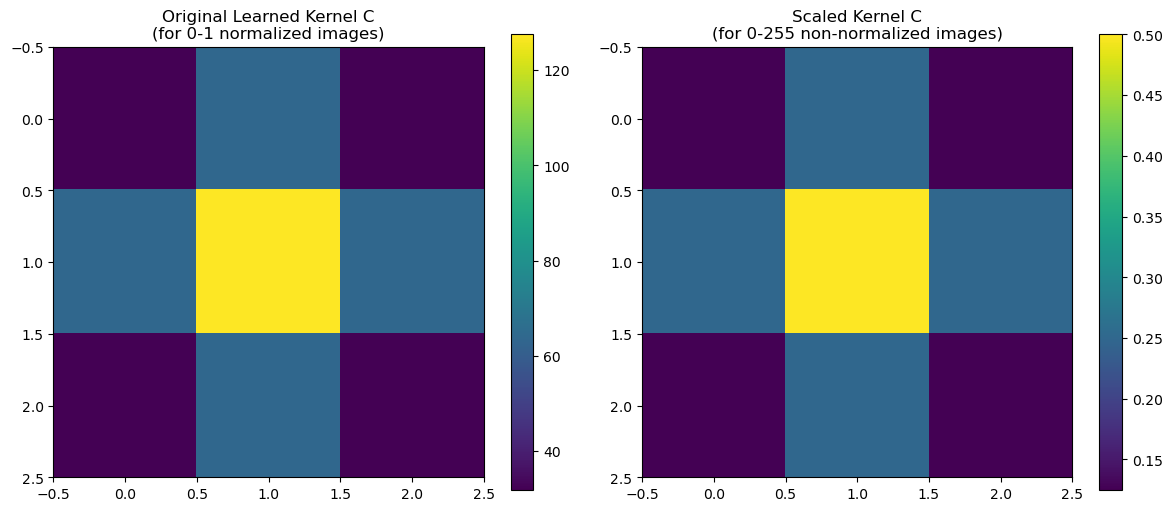

Original Kernel C (for normalized images):
[[ 31.875046  63.75029   31.87466 ]
 [ 63.749577 127.500084  63.75033 ]
 [ 31.875374  63.74963   31.874992]]

Scaled Kernel C (for non-normalized images):
[[0.1250002  0.25000116 0.12499867]
 [0.24999836 0.50000036 0.2500013 ]
 [0.12500148 0.24999857 0.12499998]]
Reconstructed algorithm saved to reconstructed_algos.csv with scaled kernel C


/var/folders/d3/zcslj2712p57dfxhz77sfh8r0000gn/T/ipykernel_5227/3332492013.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.kernel_C = nn.Parameter(torch.tensor(trainable_init, dtype=torch.float32).unsqueeze(0).unsqueeze(0))


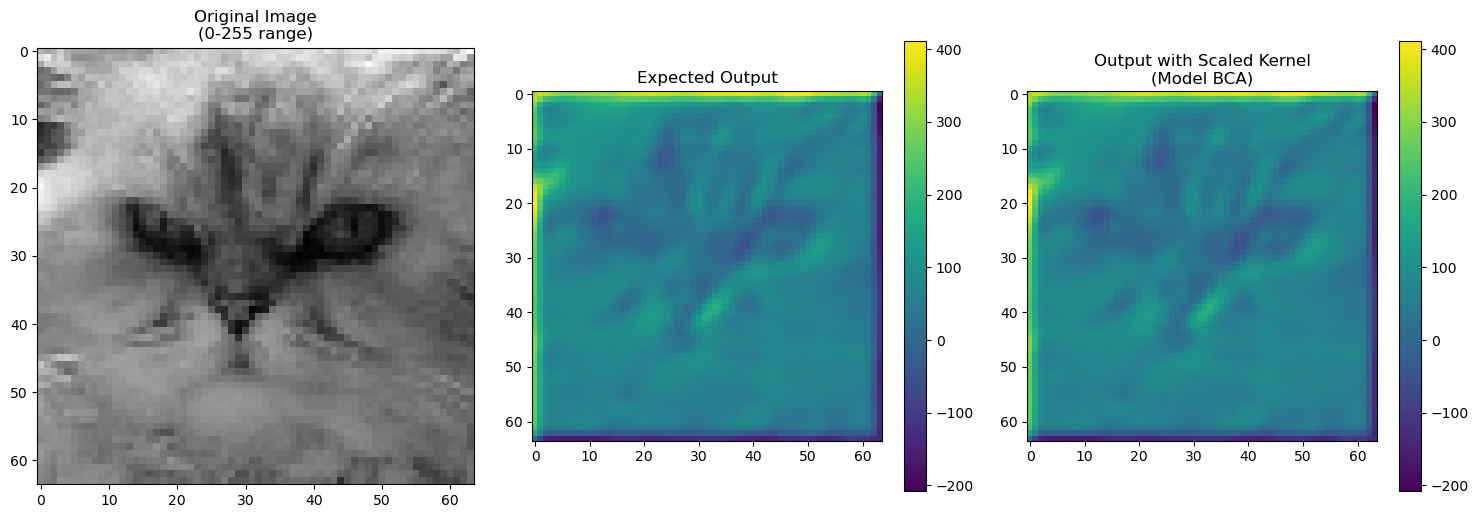

MSE between expected and actual output: 0.000000


In [20]:
# Scale the learned filter C to work with non-normalized images (0-255 range)
# If our model was trained on normalized images (0-1 range), we need to scale the filter by 1/255

# Get the best model (assuming it's already trained on normalized images)
best_model_name = 'BCA'  # Use the best model from your previous results
best_model = models[best_model_name]

# Extract the learned kernel C (which works with normalized 0-1 images)
normalized_kernel_C = best_model.kernel_C.detach().cpu().numpy().squeeze()

# Scale the kernel to work with non-normalized images (0-255 range)
# For a convolution filter, if input is scaled by factor k, the filter should be scaled by 1/k
# to produce the same output
scaling_factor = 1/255.0
unnormalized_kernel_C = normalized_kernel_C * scaling_factor

# Display both kernels for comparison
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.imshow(normalized_kernel_C, cmap='viridis')
plt.title("Original Learned Kernel C\n(for 0-1 normalized images)")
plt.colorbar()

plt.subplot(1, 2, 2)
plt.imshow(unnormalized_kernel_C, cmap='viridis')
plt.title("Scaled Kernel C\n(for 0-255 non-normalized images)")
plt.colorbar()

plt.tight_layout()
plt.show()

print("Original Kernel C (for normalized images):")
print(normalized_kernel_C)
print("\nScaled Kernel C (for non-normalized images):")
print(unnormalized_kernel_C)

# Create the reconstructed_algos.csv file with the scaled kernel
filter_order = best_model.filter_order
kernel_A_flat = kernel_A.flatten()
kernel_B_flat = kernel_B.flatten()
kernel_C_flat = unnormalized_kernel_C.flatten()  # Use the scaled kernel

reconstructed_algos = []

# Add kernels in the order they are applied
for filter_idx in filter_order:
    if filter_idx == 'A':
        reconstructed_algos.append(kernel_A_flat)
    elif filter_idx == 'B':
        reconstructed_algos.append(kernel_B_flat)
    elif filter_idx == 'C':
        reconstructed_algos.append(kernel_C_flat)

# Convert to numpy array and save to CSV
reconstructed_algos = np.array(reconstructed_algos)
np.savetxt('reconstructed_algos.csv', reconstructed_algos, delimiter=',', fmt='%.8f')
print(f"Reconstructed algorithm saved to reconstructed_algos.csv with scaled kernel C")

# Verify the scaling works by testing on a sample image
# Load a sample image without normalization
sample_img_path = os.path.join(folder, image_files[0])
sample_image = np.array(Image.open(sample_img_path))
sample_tensor = torch.tensor(sample_image, dtype=torch.float32).unsqueeze(0)  # Add batch dimension

# Create a test model with the scaled kernel
test_model = KaiNetModel(filter_order=filter_order)
with torch.no_grad():
    # Replace the trainable kernel with our scaled version
    test_model.kernel_C.data = torch.tensor(unnormalized_kernel_C, dtype=torch.float32).unsqueeze(0).unsqueeze(0)
    
    # Process the non-normalized image
    output = test_model(sample_tensor)

# Display the results
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.imshow(sample_image, cmap='gray')
plt.title("Original Image\n(0-255 range)")

plt.subplot(1, 3, 2)
plt.imshow(targets[0], cmap='viridis')
plt.title("Expected Output")
plt.colorbar()

plt.subplot(1, 3, 3)
plt.imshow(output[0].numpy(), cmap='viridis')
plt.title(f"Output with Scaled Kernel\n(Model {best_model_name})")
plt.colorbar()

plt.tight_layout()
plt.show()

# Calculate MSE between the expected output and our result
mse = ((output[0].numpy() - targets[0].numpy()) ** 2).mean()
print(f"MSE between expected and actual output: {mse:.6f}")